In [83]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [84]:
env = BlackjackEnv()

In [85]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [86]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        return np.where(Q[observation] >= np.max(Q[observation]),1,0)
    return policy_fn

In [107]:
def mc_control_importance_sampling(env, num_episodes, b_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i in range(num_episodes):
        states = []
        actions = []
        rewards = []
        W = 1
        states.append(env.reset())
        done = 0
        while not done:
            p_actions = b_policy(states[-1])
            if np.random.random() <= p_actions[0]:
                 action = 0
            else:
                action = 1
            s, r, done, _ = env.step(action)
            actions.append(action)
            states.append(s)
            rewards.append(r)
        for i, s in enumerate(states[:-1]):
            C[s] = C[s] + W
            G = sum([x * discount_factor ** j for j,x in enumerate(rewards[i:])])
            Q[s] = Q[s] + W/C[s] * (G - Q[s])
            if (np.argmax(target_policy(s)) != actions[i]):
                break
            W = W * 1 / b_policy(s)
#         print(states, rewards)
        
    return Q, target_policy

In [108]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=100000, b_policy=random_policy)

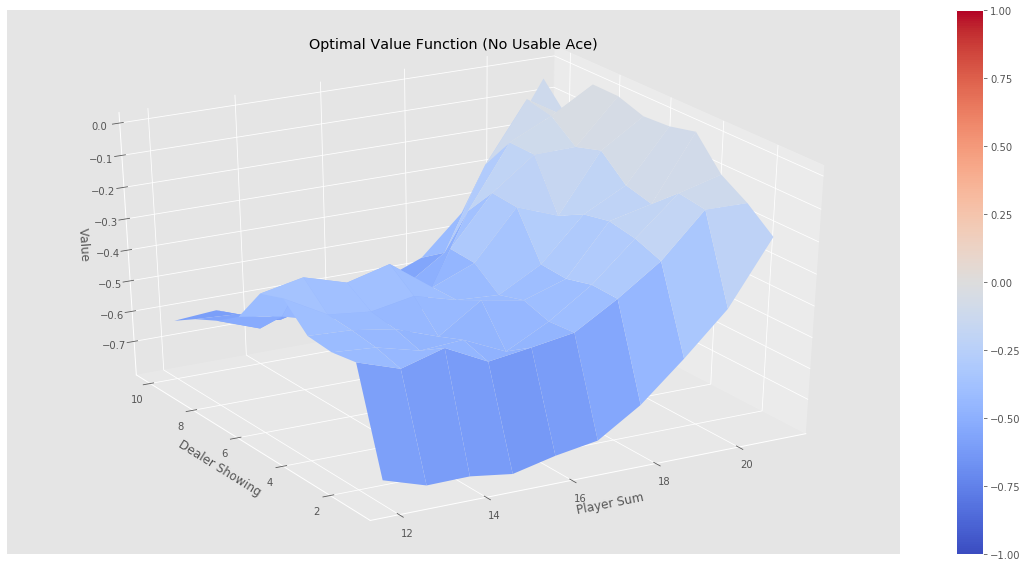

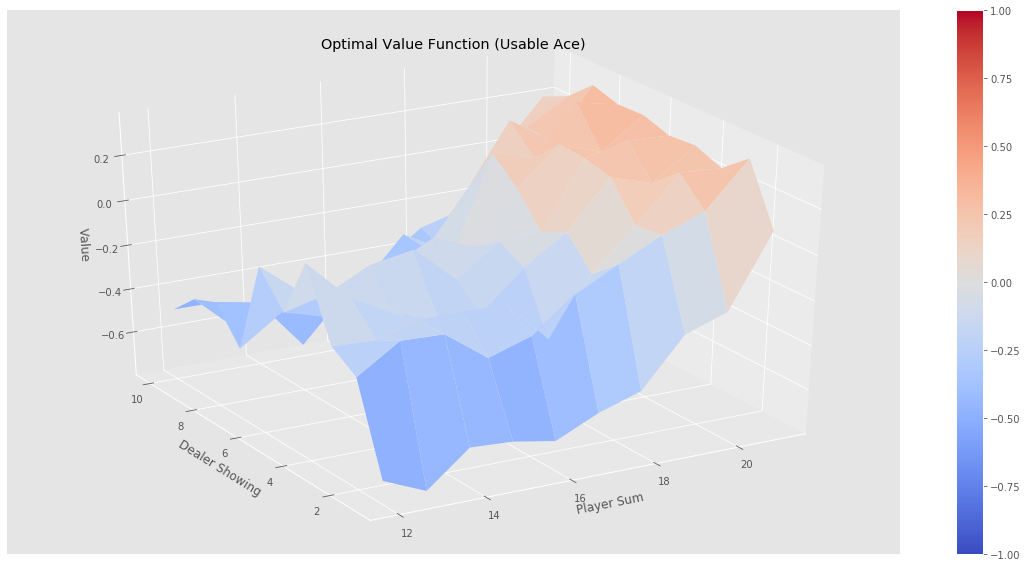

In [109]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")